# **Milestone 1: Single Character Classifier**

This is the notebook of our prototype single character classifier. This is the first milestone in our project, because being able to identify single characters is a prerequisite to identifying the characters used in the captcha 

In [ ]:
#modules
import numpy as np
import matplotlib.pyplot as plt
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
from PIL import *
from tqdm import tqdm


use_cuda = True

# **Data Loading**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
cd /content

/content


In [ ]:
ls

chars.zip  gdrive/  sample_data/  val.zip


In [ ]:
!unzip val.zip 


Archive:  val.zip
   creating: val/
   creating: val/0/
 extracting: val/0/0-1.png           
 extracting: val/0/0-10.png          
 extracting: val/0/0-11.png          
 extracting: val/0/0-12.png          
 extracting: val/0/0-13.png          
 extracting: val/0/0-14.png          
 extracting: val/0/0-15.png          
 extracting: val/0/0-16.png          
 extracting: val/0/0-17.png          
 extracting: val/0/0-18.png          
 extracting: val/0/0-19.png          
 extracting: val/0/0-2.png           
 extracting: val/0/0-20.png          
 extracting: val/0/0-21.png          
 extracting: val/0/0-22.png          
 extracting: val/0/0-23.png          
 extracting: val/0/0-24.png          
 extracting: val/0/0-25.png          
 extracting: val/0/0-26.png          
 extracting: val/0/0-27.png          
 extracting: val/0/0-28.png          
 extracting: val/0/0-29.png          
 extracting: val/0/0-3.png           
 extracting: val/0/0-30.png          
 extracting: val/0/0-31.png     

In [ ]:
transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

img_root = "/content/"
#testData = torchvision.datasets.ImageFolder(img_root + 'test', transform=transform)
trainData = torchvision.datasets.ImageFolder(img_root + 'chars', transform=transform)
valData = torchvision.datasets.ImageFolder(img_root + 'val', transform=transform)

print(  len(trainData), len(valData) )

25886 2304


In [ ]:
do_cuda = True

# **The CNN**

In [ ]:
class char_cnn(nn.Module):
    def __init__(self):
        super(char_cnn, self).__init__()
        self.name = "c_cnn"
        self.conv1 = nn.Conv2d(3, 5, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, 5)
        self.fc1 = nn.Linear(15*5*10, 32)  #width*height will change depending on previous layers, pooling, and the initial dimensions of the photo
        self.fc2 = nn.Linear(32, 36)       # there are 36 possible characters, 26 letters (A-Z) and 10 digits (0-9)

    def forward(self, x):
        
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        
        x = x.view(-1, 15*5*10)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

# **Training**

In [ ]:
def get_accuracy(model, train=False, batch_size = 64):
    if train:
        data = trainData
    else:
        data = valData

    correct = 0
    total = 0
    for imgs, labels in tqdm(torch.utils.data.DataLoader(data, batch_size=batch_size)):

        if do_cuda and torch.cuda.is_available:
            imgs = imgs.cuda()
            labels = labels.cuda()

        output = model(imgs)
        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total
  
print ('done')


def train(model, data, batch_size=64, num_epochs=30, learning_rate=0.002):
    torch.manual_seed(1000)
    train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

    iters, losses, train_acc, val_acc = [], [], [], []


    startTime = time.time() # to see how long training goes
    print("starting training")
    # training
    n = 0 # the number of iterations
    for epoch in range(num_epochs):
        print("epoch: ", epoch)
        for imgs, labels in tqdm(iter(train_loader)):

            if do_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()

            out = model(imgs)             # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

            # save the current training information
            iters.append(n)
            losses.append(float(loss)/batch_size)             # compute *average* loss
            n += 1
        print("epoch: ", epoch, " completed, checking train acc")
        train_acc.append(get_accuracy(model, train=True, batch_size=batch_size)) # compute training accuracy 
        print("checking val acc")
        val_acc.append(get_accuracy(model, train=False, batch_size=batch_size))  # compute validation accuracy
        print(("Epoch {}: Train acc: {} |"+"Validation acc: {}").format(
                epoch, # call epoch zero epoch zero
                train_acc[-1],
                val_acc[-1]))
        
        #checkpoint
        path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(model.name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
        torch.save(model.state_dict(), path)


    
    finishTime = time.time()

    delta = finishTime - startTime
    print("\nDONE TRAINING in %s seconds!\n" % delta)

    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(range(num_epochs), train_acc, label="Train")
    plt.plot(range(num_epochs), val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))
    
    
print('done')



done
done


Now we train the CNN on the data set we collected


True
starting training
epoch:  0


100%|██████████| 203/203 [00:12<00:00, 16.55it/s]


epoch:  0  completed, checking train acc


100%|██████████| 203/203 [00:11<00:00, 17.19it/s]


checking val acc


100%|██████████| 18/18 [00:00<00:00, 18.47it/s]


Epoch 0: Train acc: 0.03449741172834737 |Validation acc: 0.03993055555555555
epoch:  1


100%|██████████| 203/203 [00:12<00:00, 16.66it/s]


epoch:  1  completed, checking train acc


100%|██████████| 203/203 [00:10<00:00, 19.01it/s]


checking val acc


100%|██████████| 18/18 [00:00<00:00, 18.90it/s]


Epoch 1: Train acc: 0.24391563007030828 |Validation acc: 0.2517361111111111
epoch:  2


100%|██████████| 203/203 [00:12<00:00, 16.53it/s]


epoch:  2  completed, checking train acc


100%|██████████| 203/203 [00:10<00:00, 18.97it/s]


checking val acc


100%|██████████| 18/18 [00:00<00:00, 18.62it/s]


Epoch 2: Train acc: 0.7077957196940431 |Validation acc: 0.6857638888888888
epoch:  3


100%|██████████| 203/203 [00:12<00:00, 16.38it/s]


epoch:  3  completed, checking train acc


100%|██████████| 203/203 [00:10<00:00, 18.99it/s]


checking val acc


100%|██████████| 18/18 [00:00<00:00, 19.07it/s]


Epoch 3: Train acc: 0.8241134203816735 |Validation acc: 0.7925347222222222
epoch:  4


100%|██████████| 203/203 [00:12<00:00, 16.13it/s]


epoch:  4  completed, checking train acc


100%|██████████| 203/203 [00:10<00:00, 19.03it/s]


checking val acc


100%|██████████| 18/18 [00:00<00:00, 19.15it/s]


Epoch 4: Train acc: 0.8795874217723866 |Validation acc: 0.8563368055555556
epoch:  5


100%|██████████| 203/203 [00:12<00:00, 16.54it/s]


epoch:  5  completed, checking train acc


100%|██████████| 203/203 [00:10<00:00, 19.34it/s]


checking val acc


100%|██████████| 18/18 [00:00<00:00, 19.03it/s]


Epoch 5: Train acc: 0.9293826778953874 |Validation acc: 0.9110243055555556
epoch:  6


100%|██████████| 203/203 [00:12<00:00, 16.76it/s]


epoch:  6  completed, checking train acc


100%|██████████| 203/203 [00:10<00:00, 19.03it/s]


checking val acc


100%|██████████| 18/18 [00:00<00:00, 18.84it/s]


Epoch 6: Train acc: 0.9425171907594839 |Validation acc: 0.9283854166666666
epoch:  7


100%|██████████| 203/203 [00:12<00:00, 16.03it/s]


epoch:  7  completed, checking train acc


100%|██████████| 203/203 [00:10<00:00, 18.99it/s]


checking val acc


100%|██████████| 18/18 [00:00<00:00, 18.96it/s]


Epoch 7: Train acc: 0.964189136985243 |Validation acc: 0.9526909722222222
epoch:  8


100%|██████████| 203/203 [00:12<00:00, 16.84it/s]


epoch:  8  completed, checking train acc


100%|██████████| 203/203 [00:10<00:00, 19.22it/s]


checking val acc


100%|██████████| 18/18 [00:00<00:00, 18.89it/s]


Epoch 8: Train acc: 0.9462257590975817 |Validation acc: 0.9388020833333334
epoch:  9


100%|██████████| 203/203 [00:12<00:00, 16.75it/s]


epoch:  9  completed, checking train acc


100%|██████████| 203/203 [00:10<00:00, 19.30it/s]


checking val acc


100%|██████████| 18/18 [00:00<00:00, 18.82it/s]


Epoch 9: Train acc: 0.9658888974735378 |Validation acc: 0.9509548611111112
epoch:  10


100%|██████████| 203/203 [00:12<00:00, 16.82it/s]


epoch:  10  completed, checking train acc


100%|██████████| 203/203 [00:10<00:00, 19.12it/s]


checking val acc


100%|██████████| 18/18 [00:00<00:00, 19.25it/s]


Epoch 10: Train acc: 0.9714517499806845 |Validation acc: 0.9626736111111112
epoch:  11


100%|██████████| 203/203 [00:12<00:00, 16.07it/s]


epoch:  11  completed, checking train acc


100%|██████████| 203/203 [00:10<00:00, 19.23it/s]


checking val acc


100%|██████████| 18/18 [00:00<00:00, 18.39it/s]


Epoch 11: Train acc: 0.9782507919338639 |Validation acc: 0.9670138888888888
epoch:  12


100%|██████████| 203/203 [00:12<00:00, 16.66it/s]


epoch:  12  completed, checking train acc


100%|██████████| 203/203 [00:10<00:00, 18.99it/s]


checking val acc


100%|██████████| 18/18 [00:00<00:00, 19.18it/s]


Epoch 12: Train acc: 0.980645908985552 |Validation acc: 0.9674479166666666
epoch:  13


100%|██████████| 203/203 [00:12<00:00, 16.46it/s]


epoch:  13  completed, checking train acc


100%|██████████| 203/203 [00:11<00:00, 18.20it/s]


checking val acc


100%|██████████| 18/18 [00:00<00:00, 19.22it/s]


Epoch 13: Train acc: 0.985783821370625 |Validation acc: 0.9748263888888888
epoch:  14


100%|██████████| 203/203 [00:12<00:00, 16.63it/s]


epoch:  14  completed, checking train acc


100%|██████████| 203/203 [00:10<00:00, 19.29it/s]


checking val acc


100%|██████████| 18/18 [00:00<00:00, 19.04it/s]


Epoch 14: Train acc: 0.9831955497179943 |Validation acc: 0.97265625
epoch:  15


100%|██████████| 203/203 [00:12<00:00, 16.83it/s]


epoch:  15  completed, checking train acc


100%|██████████| 203/203 [00:10<00:00, 19.11it/s]


checking val acc


100%|██████████| 18/18 [00:00<00:00, 18.65it/s]


Epoch 15: Train acc: 0.9878312601406165 |Validation acc: 0.9791666666666666
epoch:  16


100%|██████████| 203/203 [00:12<00:00, 16.44it/s]


epoch:  16  completed, checking train acc


100%|██████████| 203/203 [00:10<00:00, 19.03it/s]


checking val acc


100%|██████████| 18/18 [00:00<00:00, 18.75it/s]


Epoch 16: Train acc: 0.9812640037085684 |Validation acc: 0.9704861111111112
epoch:  17


100%|██████████| 203/203 [00:12<00:00, 16.71it/s]


epoch:  17  completed, checking train acc


100%|██████████| 203/203 [00:11<00:00, 18.27it/s]


checking val acc


100%|██████████| 18/18 [00:00<00:00, 19.46it/s]


Epoch 17: Train acc: 0.9913466738777718 |Validation acc: 0.98046875
epoch:  18


100%|██████████| 203/203 [00:12<00:00, 16.73it/s]


epoch:  18  completed, checking train acc


100%|██████████| 203/203 [00:10<00:00, 18.78it/s]


checking val acc


100%|██████████| 18/18 [00:00<00:00, 18.70it/s]


Epoch 18: Train acc: 0.9913853047979603 |Validation acc: 0.9796006944444444
epoch:  19


100%|██████████| 203/203 [00:12<00:00, 16.56it/s]


epoch:  19  completed, checking train acc


100%|██████████| 203/203 [00:10<00:00, 19.35it/s]


checking val acc


100%|██████████| 18/18 [00:00<00:00, 19.05it/s]


Epoch 19: Train acc: 0.991732983079657 |Validation acc: 0.9778645833333334
epoch:  20


100%|██████████| 203/203 [00:12<00:00, 16.69it/s]


epoch:  20  completed, checking train acc


100%|██████████| 203/203 [00:11<00:00, 18.15it/s]


checking val acc


100%|██████████| 18/18 [00:00<00:00, 19.20it/s]


Epoch 20: Train acc: 0.9924283396430503 |Validation acc: 0.98046875
epoch:  21


100%|██████████| 203/203 [00:12<00:00, 16.60it/s]


epoch:  21  completed, checking train acc


100%|██████████| 203/203 [00:10<00:00, 19.20it/s]


checking val acc


100%|██████████| 18/18 [00:00<00:00, 19.22it/s]


Epoch 21: Train acc: 0.9945530402534188 |Validation acc: 0.984375
epoch:  22


100%|██████████| 203/203 [00:12<00:00, 16.84it/s]


epoch:  22  completed, checking train acc


100%|██████████| 203/203 [00:10<00:00, 19.50it/s]


checking val acc


100%|██████████| 18/18 [00:00<00:00, 18.38it/s]


Epoch 22: Train acc: 0.9931623271266321 |Validation acc: 0.9796006944444444
epoch:  23


100%|██████████| 203/203 [00:12<00:00, 16.75it/s]


epoch:  23  completed, checking train acc


100%|██████████| 203/203 [00:10<00:00, 19.26it/s]


checking val acc


100%|██████████| 18/18 [00:00<00:00, 19.65it/s]


Epoch 23: Train acc: 0.9952097658966237 |Validation acc: 0.984375
epoch:  24


100%|██████████| 203/203 [00:12<00:00, 16.04it/s]


epoch:  24  completed, checking train acc


100%|██████████| 203/203 [00:10<00:00, 19.31it/s]


checking val acc


100%|██████████| 18/18 [00:00<00:00, 19.33it/s]


Epoch 24: Train acc: 0.995750598779263 |Validation acc: 0.9822048611111112
epoch:  25


100%|██████████| 203/203 [00:12<00:00, 16.87it/s]


epoch:  25  completed, checking train acc


100%|██████████| 203/203 [00:10<00:00, 19.29it/s]


checking val acc


100%|██████████| 18/18 [00:00<00:00, 19.16it/s]


Epoch 25: Train acc: 0.9943598856524762 |Validation acc: 0.9852430555555556
epoch:  26


100%|██████████| 203/203 [00:12<00:00, 16.88it/s]


epoch:  26  completed, checking train acc


100%|██████████| 203/203 [00:10<00:00, 19.35it/s]


checking val acc


100%|██████████| 18/18 [00:00<00:00, 19.14it/s]


Epoch 26: Train acc: 0.995905122460017 |Validation acc: 0.9839409722222222
epoch:  27


100%|██████████| 203/203 [00:12<00:00, 16.11it/s]


epoch:  27  completed, checking train acc


100%|██████████| 203/203 [00:10<00:00, 19.55it/s]


checking val acc


100%|██████████| 18/18 [00:00<00:00, 18.92it/s]


Epoch 27: Train acc: 0.9957892296994515 |Validation acc: 0.984375
epoch:  28


100%|██████████| 203/203 [00:12<00:00, 16.91it/s]


epoch:  28  completed, checking train acc


100%|██████████| 203/203 [00:10<00:00, 19.05it/s]


checking val acc


100%|██████████| 18/18 [00:00<00:00, 19.46it/s]


Epoch 28: Train acc: 0.9954029204975663 |Validation acc: 0.9852430555555556
epoch:  29


100%|██████████| 203/203 [00:12<00:00, 16.32it/s]


epoch:  29  completed, checking train acc


100%|██████████| 203/203 [00:10<00:00, 19.54it/s]


checking val acc


100%|██████████| 18/18 [00:00<00:00, 19.29it/s]


Epoch 29: Train acc: 0.9936645290890829 |Validation acc: 0.9835069444444444
epoch:  30


100%|██████████| 203/203 [00:12<00:00, 16.73it/s]


epoch:  30  completed, checking train acc


100%|██████████| 203/203 [00:10<00:00, 19.40it/s]


checking val acc


100%|██████████| 18/18 [00:00<00:00, 19.52it/s]


Epoch 30: Train acc: 0.9967936336243529 |Validation acc: 0.9865451388888888
epoch:  31


100%|██████████| 203/203 [00:12<00:00, 16.66it/s]


epoch:  31  completed, checking train acc


100%|██████████| 203/203 [00:10<00:00, 19.52it/s]


checking val acc


100%|██████████| 18/18 [00:00<00:00, 19.85it/s]


Epoch 31: Train acc: 0.9945144093332303 |Validation acc: 0.9800347222222222
epoch:  32


100%|██████████| 203/203 [00:12<00:00, 16.86it/s]


epoch:  32  completed, checking train acc


100%|██████████| 203/203 [00:10<00:00, 19.27it/s]


checking val acc


100%|██████████| 18/18 [00:00<00:00, 19.07it/s]


Epoch 32: Train acc: 0.9961755389013366 |Validation acc: 0.984375
epoch:  33


100%|██████████| 203/203 [00:12<00:00, 16.87it/s]


epoch:  33  completed, checking train acc


100%|██████████| 203/203 [00:10<00:00, 19.61it/s]


checking val acc


100%|██████████| 18/18 [00:00<00:00, 19.56it/s]


Epoch 33: Train acc: 0.9905740554740013 |Validation acc: 0.9787326388888888
epoch:  34


100%|██████████| 203/203 [00:11<00:00, 16.93it/s]


epoch:  34  completed, checking train acc


100%|██████████| 203/203 [00:10<00:00, 19.50it/s]


checking val acc


100%|██████████| 18/18 [00:00<00:00, 19.52it/s]


Epoch 34: Train acc: 0.995982384300394 |Validation acc: 0.9830729166666666
epoch:  35


100%|██████████| 203/203 [00:11<00:00, 16.98it/s]


epoch:  35  completed, checking train acc


100%|██████████| 203/203 [00:10<00:00, 19.27it/s]


checking val acc


100%|██████████| 18/18 [00:00<00:00, 19.58it/s]


Epoch 35: Train acc: 0.9971413119060496 |Validation acc: 0.9856770833333334
epoch:  36


100%|██████████| 203/203 [00:11<00:00, 17.08it/s]


epoch:  36  completed, checking train acc


100%|██████████| 203/203 [00:10<00:00, 19.74it/s]


checking val acc


100%|██████████| 18/18 [00:00<00:00, 19.02it/s]


Epoch 36: Train acc: 0.9980684539905741 |Validation acc: 0.9865451388888888
epoch:  37


100%|██████████| 203/203 [00:11<00:00, 16.92it/s]


epoch:  37  completed, checking train acc


100%|██████████| 203/203 [00:10<00:00, 19.58it/s]


checking val acc


100%|██████████| 18/18 [00:01<00:00, 17.43it/s]


Epoch 37: Train acc: 0.9988024414741559 |Validation acc: 0.98828125
epoch:  38


100%|██████████| 203/203 [00:12<00:00, 16.78it/s]


epoch:  38  completed, checking train acc


100%|██████████| 203/203 [00:10<00:00, 19.36it/s]


checking val acc


100%|██████████| 18/18 [00:01<00:00, 17.58it/s]


Epoch 38: Train acc: 0.9985706559530249 |Validation acc: 0.9852430555555556
epoch:  39


100%|██████████| 203/203 [00:11<00:00, 17.03it/s]


epoch:  39  completed, checking train acc


100%|██████████| 203/203 [00:10<00:00, 19.17it/s]


checking val acc


100%|██████████| 18/18 [00:00<00:00, 19.73it/s]


Epoch 39: Train acc: 0.9982229776713282 |Validation acc: 0.9869791666666666
epoch:  40


100%|██████████| 203/203 [00:12<00:00, 16.77it/s]


epoch:  40  completed, checking train acc


100%|██████████| 203/203 [00:10<00:00, 19.16it/s]


checking val acc


100%|██████████| 18/18 [00:00<00:00, 18.97it/s]


Epoch 40: Train acc: 0.9983388704318937 |Validation acc: 0.9848090277777778
epoch:  41


100%|██████████| 203/203 [00:12<00:00, 16.76it/s]


epoch:  41  completed, checking train acc


100%|██████████| 203/203 [00:10<00:00, 19.22it/s]


checking val acc


100%|██████████| 18/18 [00:00<00:00, 19.41it/s]


Epoch 41: Train acc: 0.9963686935022792 |Validation acc: 0.984375
epoch:  42


100%|██████████| 203/203 [00:12<00:00, 16.80it/s]


epoch:  42  completed, checking train acc


100%|██████████| 203/203 [00:10<00:00, 18.89it/s]


checking val acc


100%|██████████| 18/18 [00:00<00:00, 19.20it/s]


Epoch 42: Train acc: 0.9989955960750985 |Validation acc: 0.9878472222222222
epoch:  43


100%|██████████| 203/203 [00:11<00:00, 16.99it/s]


epoch:  43  completed, checking train acc


100%|██████████| 203/203 [00:10<00:00, 19.13it/s]


checking val acc


100%|██████████| 18/18 [00:00<00:00, 19.20it/s]


Epoch 43: Train acc: 0.9988797033145329 |Validation acc: 0.9856770833333334
epoch:  44


100%|██████████| 203/203 [00:12<00:00, 16.85it/s]


epoch:  44  completed, checking train acc


100%|██████████| 203/203 [00:10<00:00, 19.23it/s]


checking val acc


100%|██████████| 18/18 [00:00<00:00, 19.52it/s]


Epoch 44: Train acc: 0.9987638105539673 |Validation acc: 0.9861111111111112
epoch:  45


100%|██████████| 203/203 [00:11<00:00, 17.00it/s]


epoch:  45  completed, checking train acc


100%|██████████| 203/203 [00:10<00:00, 19.20it/s]


checking val acc


100%|██████████| 18/18 [00:00<00:00, 18.08it/s]


Epoch 45: Train acc: 0.9987638105539673 |Validation acc: 0.9856770833333334
epoch:  46


100%|██████████| 203/203 [00:12<00:00, 16.74it/s]


epoch:  46  completed, checking train acc


100%|██████████| 203/203 [00:10<00:00, 19.06it/s]


checking val acc


100%|██████████| 18/18 [00:01<00:00, 17.86it/s]


Epoch 46: Train acc: 0.9928146488449355 |Validation acc: 0.9822048611111112
epoch:  47


100%|██████████| 203/203 [00:12<00:00, 16.65it/s]


epoch:  47  completed, checking train acc


100%|██████████| 203/203 [00:10<00:00, 19.48it/s]


checking val acc


100%|██████████| 18/18 [00:00<00:00, 19.61it/s]


Epoch 47: Train acc: 0.9990728579154755 |Validation acc: 0.9856770833333334
epoch:  48


100%|██████████| 203/203 [00:12<00:00, 16.61it/s]


epoch:  48  completed, checking train acc


100%|██████████| 203/203 [00:10<00:00, 19.23it/s]


checking val acc


100%|██████████| 18/18 [00:00<00:00, 19.34it/s]


Epoch 48: Train acc: 0.9986092868732134 |Validation acc: 0.9852430555555556
epoch:  49


100%|██████████| 203/203 [00:12<00:00, 16.83it/s]


epoch:  49  completed, checking train acc


100%|██████████| 203/203 [00:10<00:00, 19.62it/s]


checking val acc


100%|██████████| 18/18 [00:00<00:00, 18.81it/s]


Epoch 49: Train acc: 0.9990728579154755 |Validation acc: 0.9869791666666666

DONE TRAINING in 1188.0975811481476 seconds!



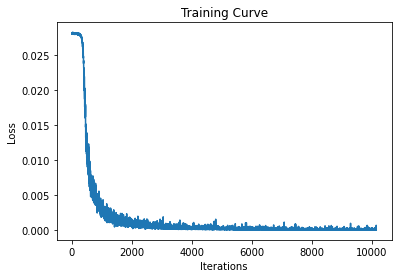

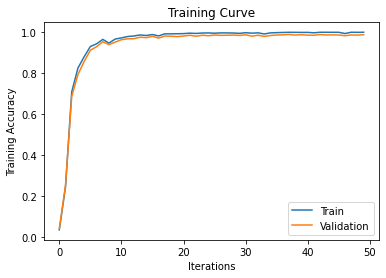

Final Training Accuracy: 0.9990728579154755
Final Validation Accuracy: 0.9869791666666666


In [ ]:
sccnn = char_cnn()
sccnn.cuda()
print(torch.cuda.is_available())
train(sccnn,  trainData, 128, 50)
#model_path = get_model_name("c_cnn", batch_size=64, learning_rate=0.01, epoch=49)
#plot_training_curve(model_path)